In [1]:
!pip -q install -e ./../../BatchDetect

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Patch-level methods evaluation

Evaluate the performance of patch-level methods, such as stain normalization or stain augmentation techniques.

## Reading metadata

In [3]:
dataset = 'CRC'  # TODO make work for other datasets

In [4]:
# create metadata dataframe from clini_table and folder structure
base_dir = Path(f'/home/ubuntu/data/BatchDetectData/BatchDetect{dataset}')
clini_table = pd.read_csv(base_dir / 'BatchDetectCRC_clini.csv')

labels = list(clini_table.columns)  # or costum list
labels.remove('PATIENT')
labels.remove('AGE')

metadata_path = Path(base_dir / 'metadata.csv')
if metadata_path.exists():
    metadata = pd.read_csv(metadata_path)
else:
    # metadata with columns: file, label (MSI-H), submission site
    patch_list = list(base_dir.glob('**/*.jpeg'))
    print('Number of patches:', len(patch_list))

    submission_site = [patch.parent.parent.name for patch in patch_list]
    metadata = pd.DataFrame(list(zip(patch_list, submission_site)), columns=['file', 'dataset'])

    for l in labels:
        label = [clini_table[l][clini_table['PATIENT'] == patch.name.split('_')[0]].item() for patch in patch_list]
        metadata[l] = label
    metadata.to_csv(metadata_path, index=False)

In [5]:
metadata.dataset.value_counts()

dataset
CPTAC    3550
AA       1120
A6       1050
G4        860
CM        850
D5        790
DM        510
PAIP      470
AZ        450
Name: count, dtype: int64

In [6]:
metadata

,file,dataset,GENDER,AGE,STAGE ORIGINAL,isMSIH
0,/home/ubuntu/data/BatchDetectData/BatchDetectC...,AZ,male,77.0,3.0,nonMSIH
1,/home/ubuntu/data/BatchDetectData/BatchDetectC...,AZ,male,77.0,3.0,nonMSIH
2,/home/ubuntu/data/BatchDetectData/BatchDetectC...,AZ,male,77.0,3.0,nonMSIH
3,/home/ubuntu/data/BatchDetectData/BatchDetectC...,AZ,male,77.0,3.0,nonMSIH
4,/home/ubuntu/data/BatchDetectData/BatchDetectC...,AZ,male,77.0,3.0,nonMSIH
...,...,...,...,...,...,...
9645,/home/ubuntu/data/BatchDetectData/BatchDetectC...,A6,male,62.0,NaN,NaN
9646,/home/ubuntu/data/BatchDetectData/BatchDetectC...,A6,male,62.0,NaN,NaN
9647,/home/ubuntu/data/BatchDetectData/BatchDetectC...,A6,male,62.0,NaN,NaN
9648,/home/ubuntu/data/BatchDetectData/BatchDetectC...,A6,male,62.0,NaN,NaN


## Features
Create or load features

In [7]:
method = "original"  # TODO extend this to list of methods
features = 'first_and_second_order'  # TODO extend this to list of feature extractors

In [8]:
from batchdetect.image import first_and_second_order, resnet, ctranspath

df_features_path = base_dir / f'{method}_{features}_features.csv'

if df_features_path.exists():
    df_features = pd.read_csv(df_features_path)
else:
    if features == 'first_and_second_order':
        df_features = first_and_second_order(metadata)
    elif features == 'resnet':
        df_features = resnet(metadata)
    elif features == 'ctranspath':
        df_features = ctranspath(metadata)
    
    df_features.to_csv(df_features_path)

In [9]:
df_features.columns

Index(['Unnamed: 0', 'mean_intensity_Ch1', 'std_intensity_Ch1',
       'kurtosis_intensity_Ch1', 'skew_intensity_Ch1', 'min_intensity_Ch1',
       'max_intensity_Ch1', 'shannon_entropy_Ch1', 'contrast_Ch1',
       'dissimilarity_Ch1', 'homogeneity_Ch1', 'ASM_Ch1', 'energy_Ch1',
       'correlation_Ch1', 'mean_intensity_Ch2', 'std_intensity_Ch2',
       'kurtosis_intensity_Ch2', 'skew_intensity_Ch2', 'min_intensity_Ch2',
       'max_intensity_Ch2', 'shannon_entropy_Ch2', 'contrast_Ch2',
       'dissimilarity_Ch2', 'homogeneity_Ch2', 'ASM_Ch2', 'energy_Ch2',
       'correlation_Ch2', 'mean_intensity_Ch3', 'std_intensity_Ch3',
       'kurtosis_intensity_Ch3', 'skew_intensity_Ch3', 'min_intensity_Ch3',
       'max_intensity_Ch3', 'shannon_entropy_Ch3', 'contrast_Ch3',
       'dissimilarity_Ch3', 'homogeneity_Ch3', 'ASM_Ch3', 'energy_Ch3',
       'correlation_Ch3'],
      dtype='object')

## Let's see if there is a batch effect in the data

In [10]:
from batchdetect.batchdetect import BatchDetect

bd = BatchDetect(metadata.loc[:,[*labels,"dataset"]], df_features)

/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/uma

In [11]:
df_features

,Unnamed: 0,mean_intensity_Ch1,std_intensity_Ch1,kurtosis_intensity_Ch1,skew_intensity_Ch1,min_intensity_Ch1,max_intensity_Ch1,shannon_entropy_Ch1,contrast_Ch1,dissimilarity_Ch1,...,skew_intensity_Ch3,min_intensity_Ch3,max_intensity_Ch3,shannon_entropy_Ch3,contrast_Ch3,dissimilarity_Ch3,homogeneity_Ch3,ASM_Ch3,energy_Ch3,correlation_Ch3
0,0,166.591257,49.287548,-0.711537,-0.323687,22,255,7.556028,2859.637215,40.754249,...,0.173680,50,255,7.369778,1775.041874,32.347678,0.035360,0.000065,0.008081,0.500311
1,1,188.826411,40.874701,-0.776553,-0.548350,37,255,7.144074,1552.336883,28.416536,...,-0.543206,39,255,7.252225,1749.158977,29.796612,0.048072,0.000111,0.010516,0.585720
2,2,176.348162,47.188270,-0.598370,-0.423457,13,255,7.464198,2406.733408,36.372864,...,-0.021715,34,255,7.431500,2069.052067,34.090267,0.037385,0.000064,0.007972,0.507436
3,3,189.408027,43.894388,-0.171108,-0.689353,24,255,7.291305,1854.412679,31.239949,...,-0.185570,50,255,7.291253,1511.955384,28.833504,0.045333,0.000089,0.009458,0.586127
4,4,186.269538,43.703226,-0.315919,-0.626630,28,255,7.307609,2099.422918,33.241337,...,-0.183336,50,255,7.305133,1738.680534,30.868621,0.042827,0.000083,0.009112,0.526963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9645,9645,120.678192,44.968515,-0.120511,0.358228,0,255,7.484169,2028.791675,34.426035,...,0.759254,33,255,6.949326,953.553352,23.629957,0.045186,0.000130,0.011412,0.526318
9646,9646,170.856534,55.076867,-1.011748,-0.321930,13,255,7.560468,3376.192626,43.501320,...,-0.367023,0,255,7.684859,2899.623973,39.873149,0.036456,0.000064,0.007978,0.569789
9647,9647,141.445744,50.978787,-0.619286,-0.229566,0,255,7.657323,3085.226765,41.317111,...,0.148627,27,255,7.240685,1694.463620,31.212989,0.036019,0.000081,0.009025,0.383919
9648,9648,157.920046,40.342616,0.897326,-1.076717,0,255,7.123469,1671.900416,28.490046,...,0.057529,20,255,6.742841,814.534821,20.938639,0.054729,0.000183,0.013513,0.418455


### Visualizations

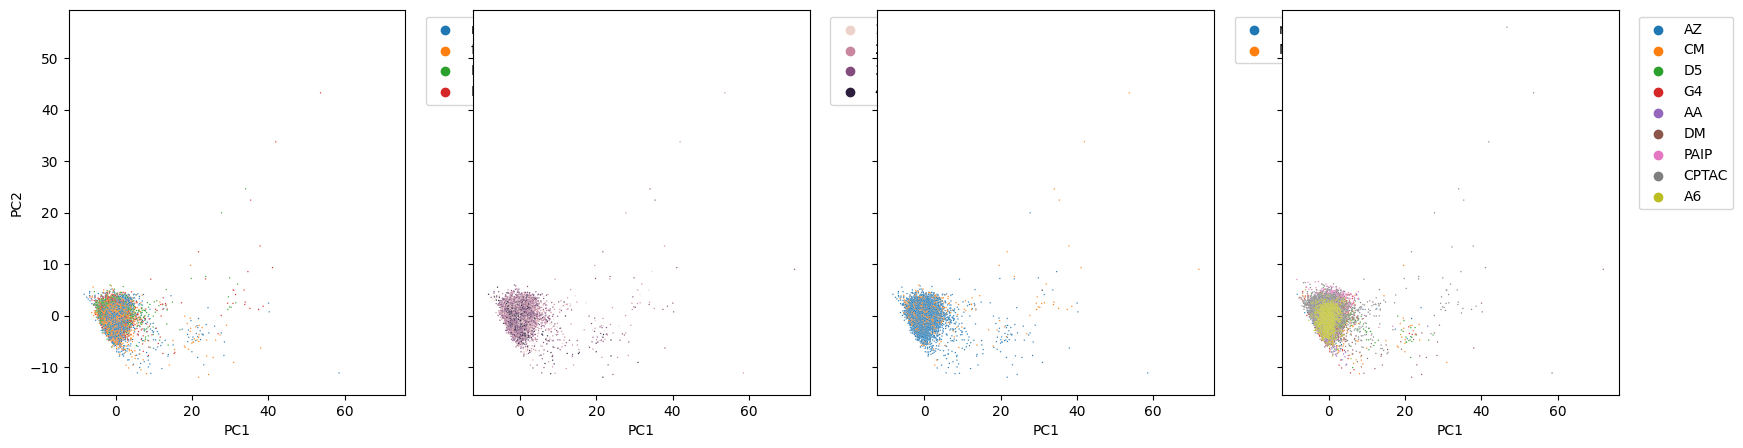

In [12]:
bd.low_dim_visualization("pca")

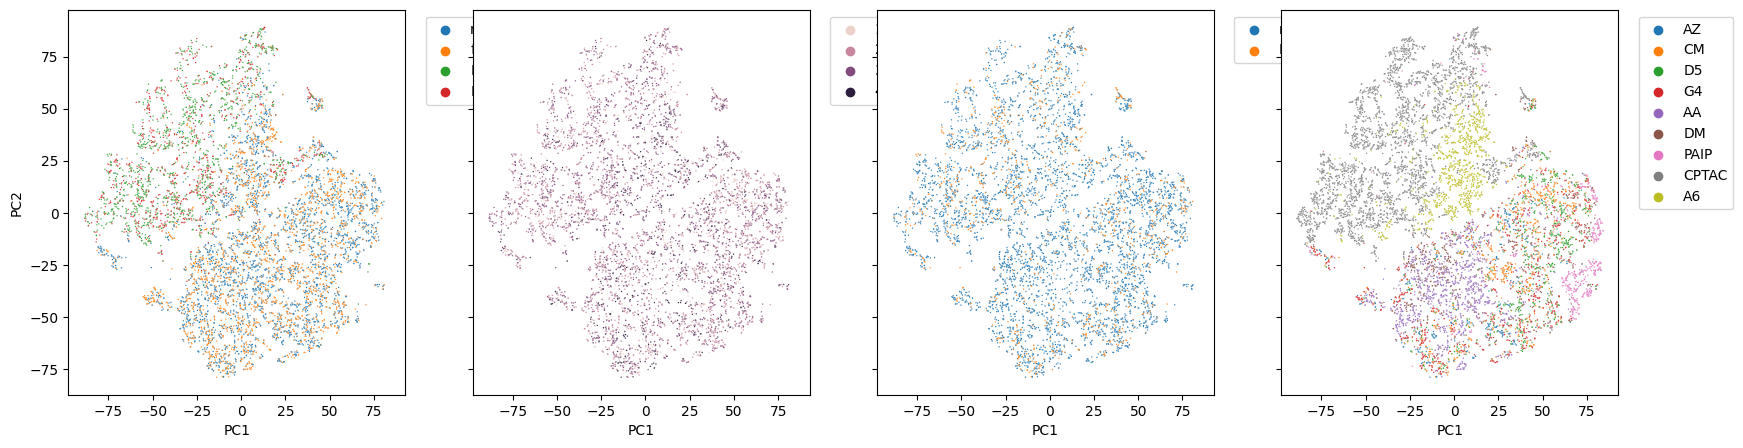

In [13]:
bd.low_dim_visualization("tsne")

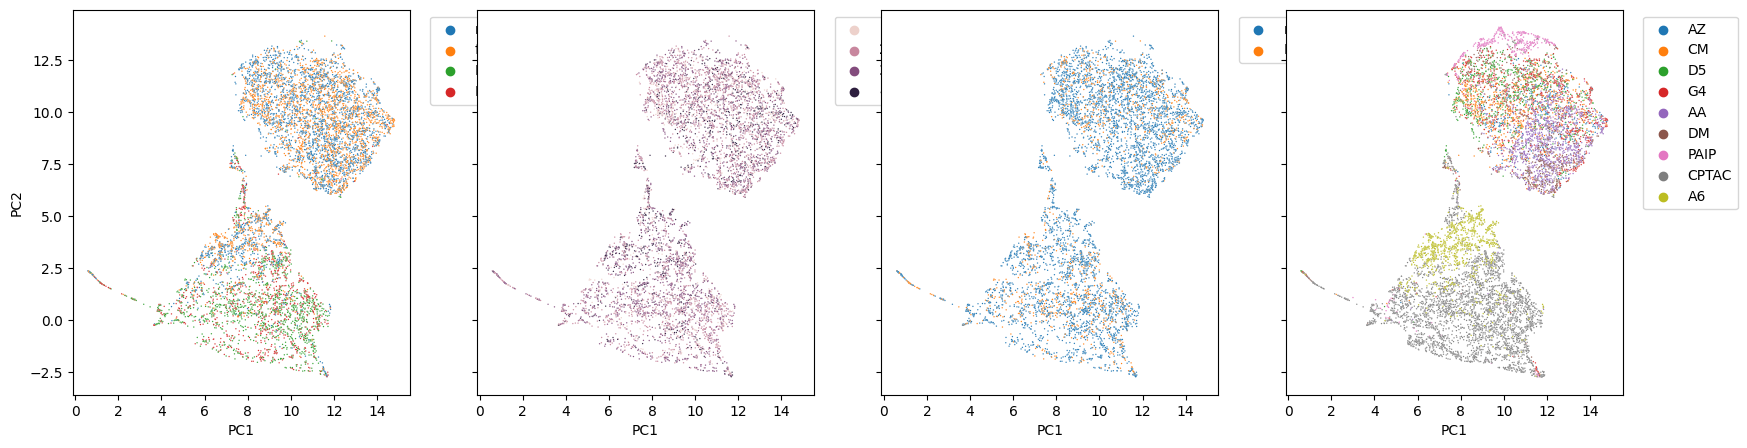

In [14]:
bd.low_dim_visualization("umap")

### Anova test of principal components vs. labels

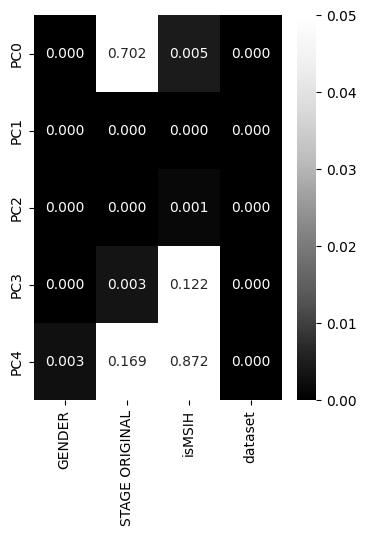

In [15]:
bd.prince_plot()

### classification test of random forest (RF) vs a random classifier

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   33.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   31.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   31.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   32.9s


comparing GENDER : MannwhitneyuResult(statistic=0.0, pvalue=7.066071930388932e-18)
comparing STAGE ORIGINAL : MannwhitneyuResult(statistic=0.0, pvalue=7.066071930388932e-18)
comparing isMSIH : MannwhitneyuResult(statistic=0.0, pvalue=7.05810774856964e-18)
comparing dataset : MannwhitneyuResult(statistic=0.0, pvalue=7.066071930388932e-18)


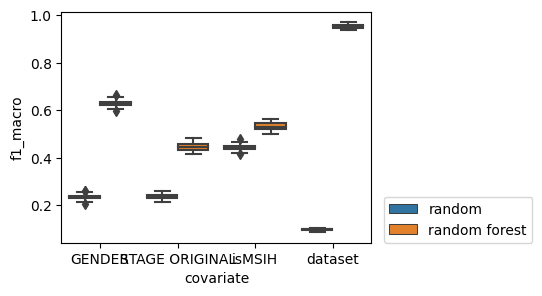

In [16]:
bd.classification_test(scorer="f1_macro")

### Clustering metrics

In [20]:
targets = [*labels, "dataset"]

from batchdetect.metrics import mean_local_diversity, silhouette_score

metrics = [mean_local_diversity, silhouette_score]
metrics_labels = [f'{m.__name__}'.replace('_', ' ').title() for m in metrics]

result_df = pd.DataFrame(columns=["Target", *metrics_labels])

for i, m in enumerate(metrics):
    res = m(metadata, targets, df_features)
    for j, t in enumerate(targets):
        result_df.loc[j, "Target"] = t
        result_df.loc[j, metrics_labels[i]] = res[t]


/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ubuntu/miniconda3/envs/batdet/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
result_df

| Metrics | Range | Aim for highest mixture |
|:-------------|:--------------:|:--------------:|
| Mean local diversity | [0, 1] | 1 |
| Silhouette score | [-1 ,1] | -1 |

In [19]:
labels

['GENDER', 'STAGE ORIGINAL', 'isMSIH']